# Econ 570 - Final Project Research Report
### Research Question: *What are the most significant factors that lead to a team having a final four appearance?*

### Group Members:

1. Danny Soulas
2. Dylan Kiratli
3. Gavin Carlson

### Appendix

Section 1: *Exploratory Data Analysis*  
Section 2: *Modeling*  
Section 3: *Bonus*   

### Data

For a more comprehensive understanding of the variables, there is data dictionary that explains the variables under the section titled "Variable" within this dataset on the kaggle page linked [here](https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset/data).

# Section 1: *Exploratory Data Analysis*

files needed = ("cbb.csv")

This section of our analysis begins with a basic understanding of the notebook given to us from Kaggle. We are seeking to understand what statistics in our dataset drive success in the College Basketball.

In [1]:
## packages required for analysis...

import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

pd.set_option('display.max_columns', None)

In [2]:
## reading file

filepath = "cbb.csv"
data = pd.read_csv(filepath)

In [3]:
data.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3523 entries, 0 to 3522
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TEAM        3523 non-null   object 
 1   CONF        3523 non-null   object 
 2   G           3523 non-null   int64  
 3   W           3523 non-null   int64  
 4   ADJOE       3523 non-null   float64
 5   ADJDE       3523 non-null   float64
 6   BARTHAG     3523 non-null   float64
 7   EFG_O       3523 non-null   float64
 8   EFG_D       3523 non-null   float64
 9   TOR         3523 non-null   float64
 10  TORD        3523 non-null   float64
 11  ORB         3523 non-null   float64
 12  DRB         3523 non-null   float64
 13  FTR         3523 non-null   float64
 14  FTRD        3523 non-null   float64
 15  2P_O        3523 non-null   float64
 16  2P_D        3523 non-null   float64
 17  3P_O        3523 non-null   float64
 18  3P_D        3523 non-null   float64
 19  ADJ_T       3523 non-null  

#### Data Transformation: *Adding additional variables*

In [5]:
## columns POSTSEASON and SEED have missing values for when that team did not make the tournament. We want to 
## replace these values to make our data more clean to work with. However, we are not going to replace SEED
## because the column is numeric and would potentially add noise to future analysis (i.e. correlation).

data['POSTSEASON'] = data['POSTSEASON'].fillna('MISSED')


In [6]:
mapping = {'MISSED': 0,
           'R68': 1,
           'R64': 2,
           'R32': 3,
           'S16': 4,
           'E8': 5,
           'F4': 6,
           '2ND': 7,
           'Champions': 8}

## adding a numeric post season column for correlation
data['POSTSEASON_NUM'] = data['POSTSEASON'].map(mapping)

## adding winning percentage
data["WIN_PCT"] = data["W"] / data["G"]

## Difference between offensive and defensive effective field goal percentages.
data['TO_RATIO'] = data['TORD'] - data['TOR']

## Net Effective Field Goal Percentage: Difference between offensive and defensive effective field goal percentages.
data['EFF_DIFF'] = data['ADJOE'] - data['ADJDE']

## A metric that combines a team's adjusted tempo (ADJ_T) with its shooting efficiency (sum of EFG_O and EFG_D).
## It reflects how effectively a team manages its shooting efficiency relative to its game pace. 
## Calculated as (ADJ_T * (EFG_O + EFG_D)) / 100. A higher value indicates a team that not only 
## plays at a faster pace but also maintains effective shooting and defensive performance.
## Pace is known as a very important aspect to the college basketball game.

data['PACE_FACTOR'] = data['ADJ_T'] * (data['EFG_O'] + data['EFG_D']) / 100


## EDA: Correlation of discrete variables:

In [7]:
### creating a correlation matrix dataframe
corr_df = data.select_dtypes(include=[np.number]).corr()

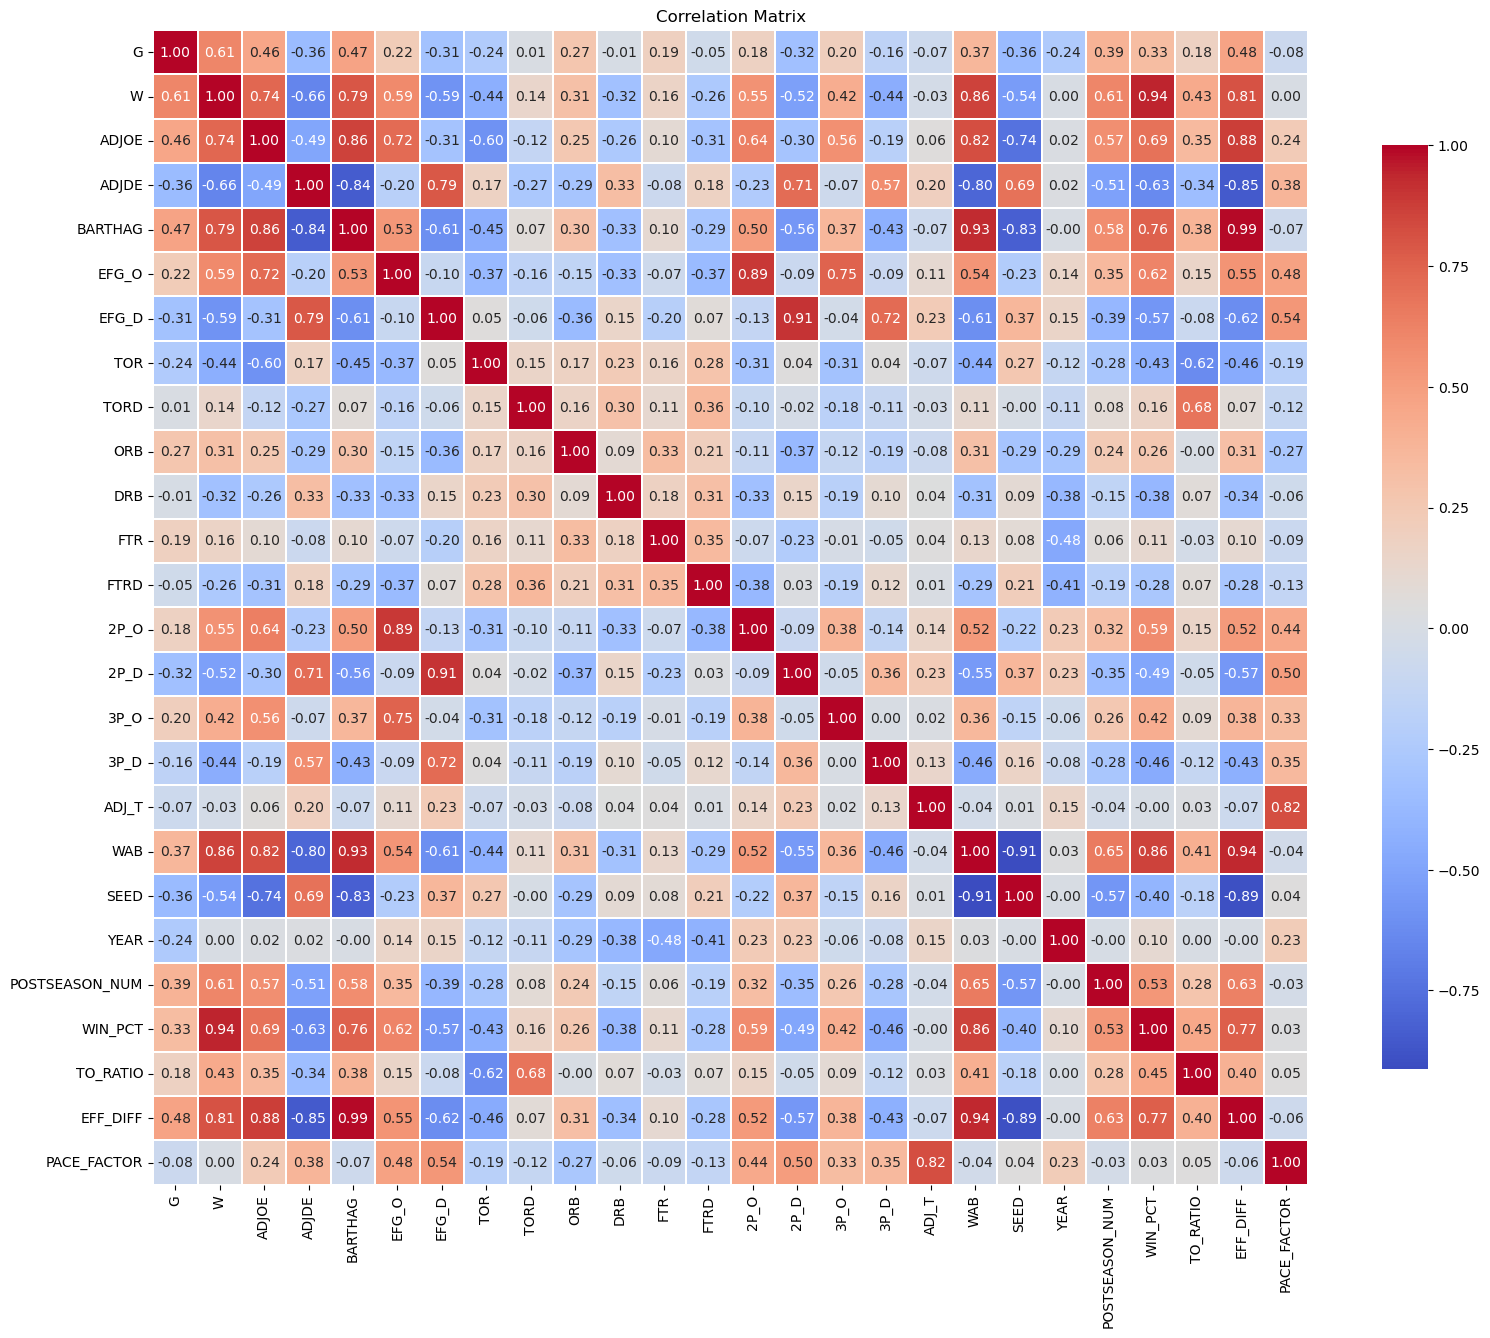

In [8]:
## figure size was not large enough at first..
plt.figure(figsize=(19, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.2, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix')

plt.show()

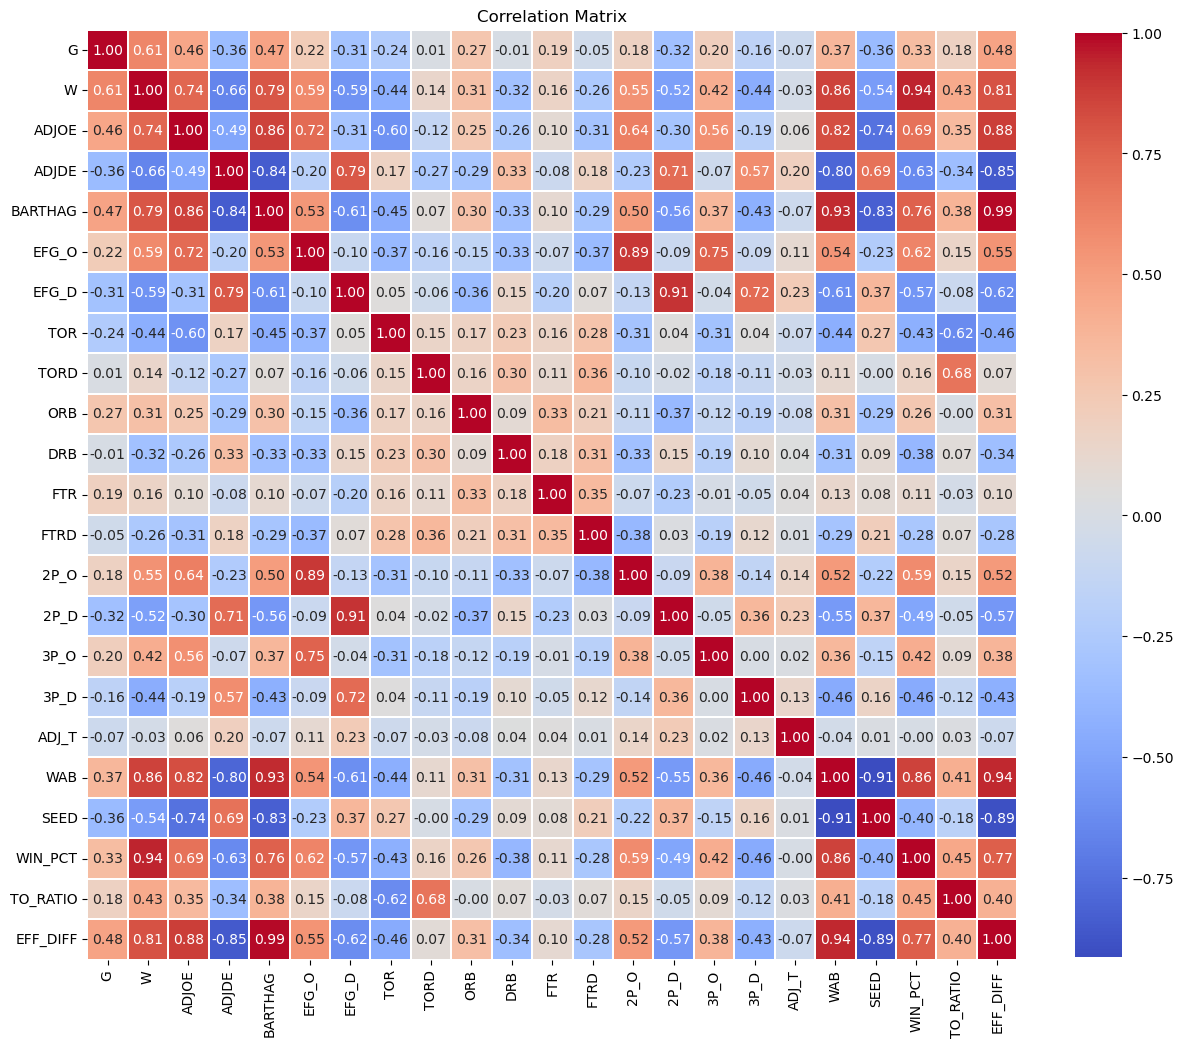

In [9]:
temp_corr_df = data.select_dtypes(include=[np.number])[['G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D', 'TOR', 'TORD', 'ORB', 'DRB',
                        'FTR', 'FTRD','2P_O','2P_D','3P_O','3P_D','ADJ_T','WAB','SEED','WIN_PCT',
                        'TO_RATIO','EFF_DIFF']].corr()

## figure size was not large enough at first..
plt.figure(figsize=(15, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(temp_corr_df, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.2, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix')
plt.savefig('correlation.jpg', format='jpeg')
plt.show()


Notes From Correlation Analysis:
* The variables that seem to correlate with seeding seem to be ADJOE, ADJDE, BARTHAG, WAB, W_PERC, EFF_DIFF

## EDA: Scatterplots
exploring relationships between variables

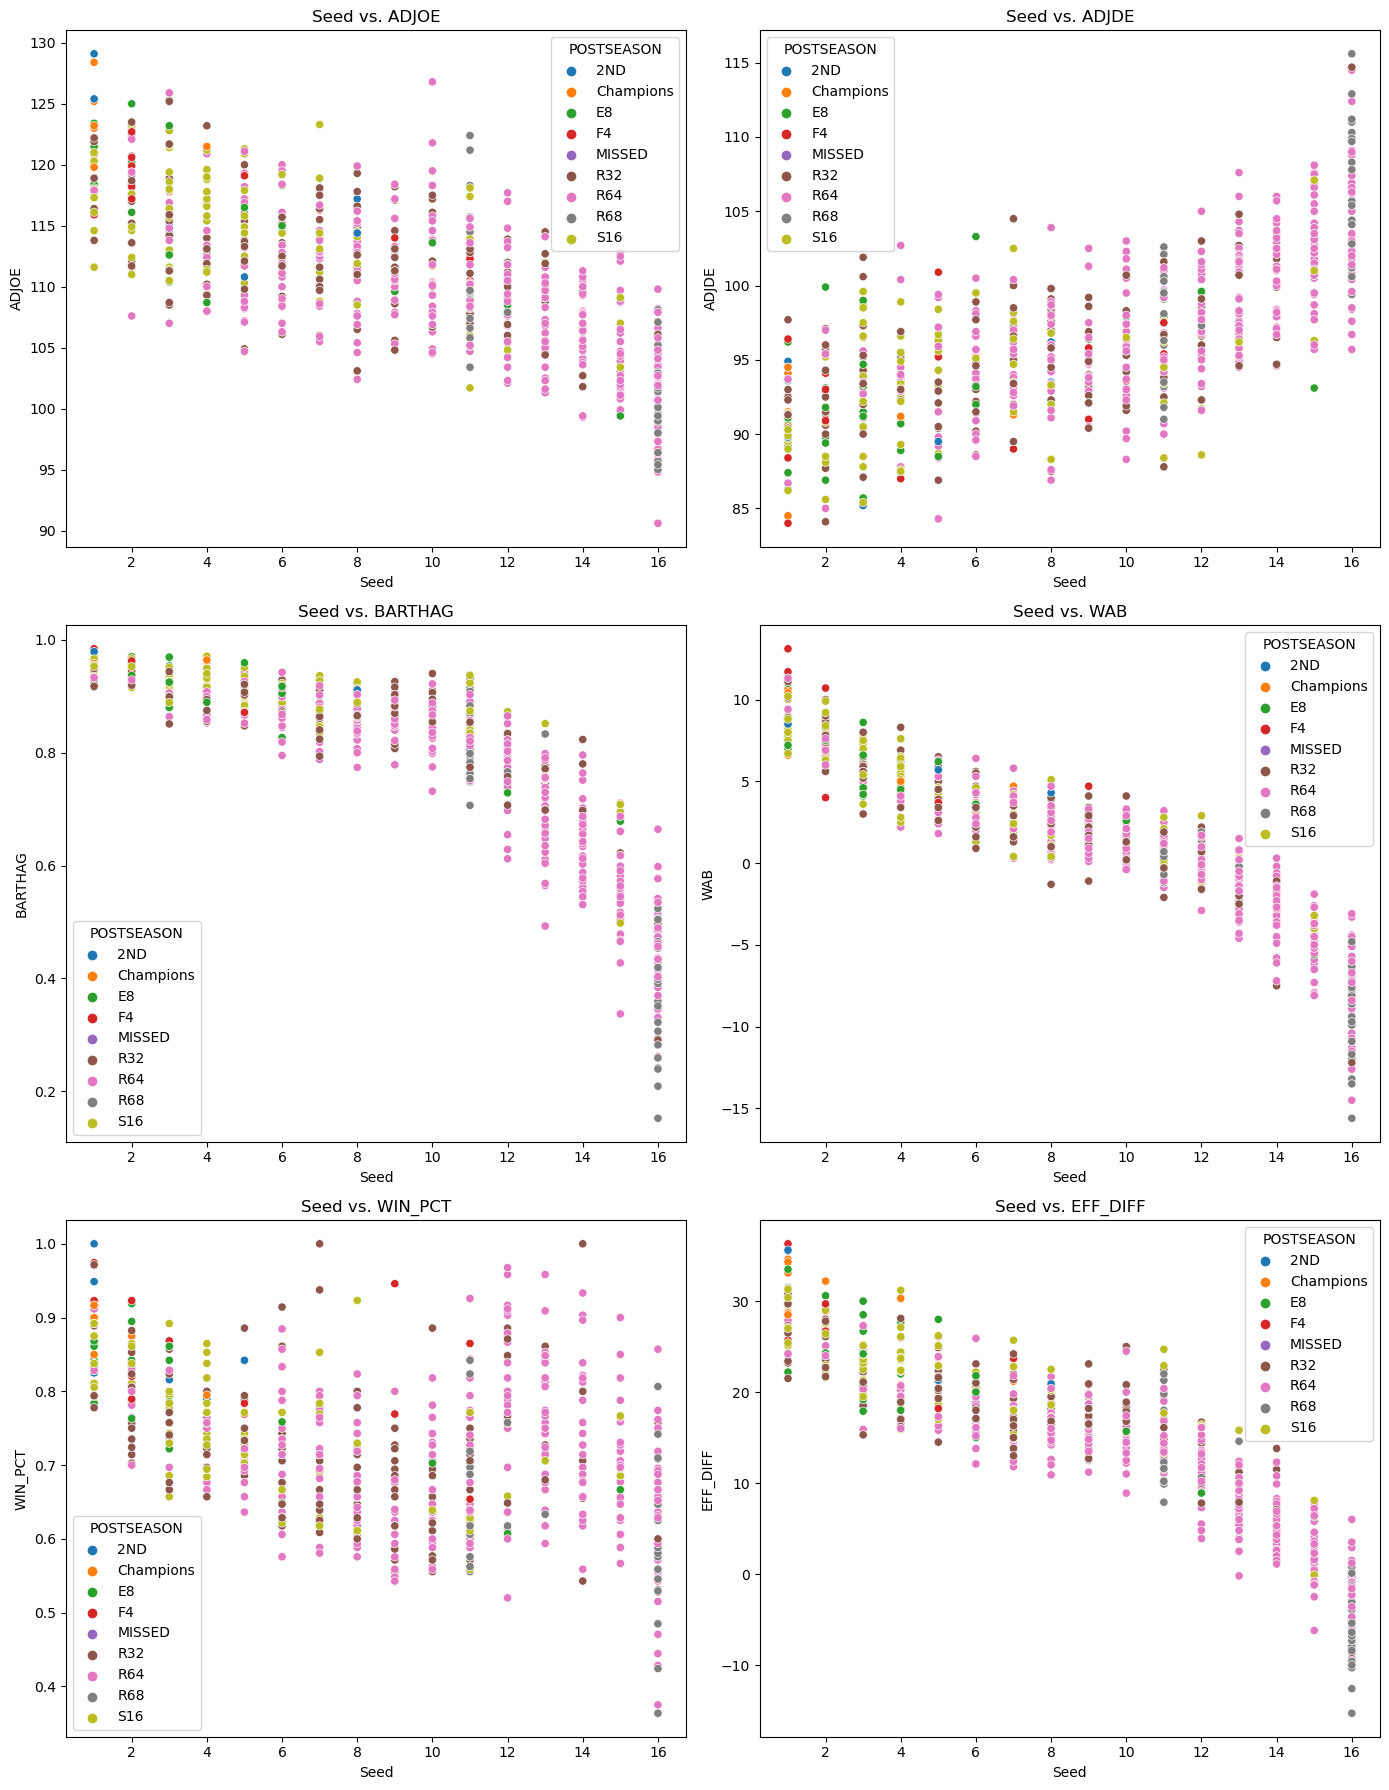

In [10]:
variables = ['ADJOE', 'ADJDE', 'BARTHAG', 'WAB', 'WIN_PCT', 'EFF_DIFF']

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
axes = axes.flatten()  # Flatten the array of axes

# Loop through the variables and create a scatter plot for each
for i, var in enumerate(variables):
    sns.scatterplot(x='SEED', y=var, data=data, ax=axes[i], hue = "POSTSEASON")
    axes[i].set_title(f'Seed vs. {var}')
    axes[i].set_xlabel('Seed')
    axes[i].set_ylabel(var)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## EDA: Boxplots

In [ ]:
## making a new column that can better be visually appropriate
data['Playoff_Depth'] = data['POSTSEASON'].map({'R64': 'Early Exit', 'R32': 'Second Round', 'S16': 'Sweet Sixteen', 'E8': 'Elite Eight', 'F4': 'Final Four', '2ND': 'Finalist', 'Champion': 'Champion'})

# Select metrics to plot
metrics = ['ADJOE', 'ADJDE', 'BARTHAG', "WIN_PCT"]
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Playoff_Depth', y=metric, data=data, order=['Early Exit', 'Second Round', 'Sweet Sixteen', 'Elite Eight', 'Final Four', 'Finalist'])
    plt.title(f'{metric} by Playoff Depth')
    plt.xlabel('Postseason Depth')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()

## EDA: Outliar Detection

What divisions are represented the most in this dataset?
What divivisons make it to the tournament the most? Deep runs in the tornamnets?


In [ ]:
data

# Section 1: *Modeling*
Part 1: Logistic Regression Model

In [ ]:
### First creating an model that will tell us if the team made the tournament or not.
### Then if that has sucess we can try to predict when a team ends up in the tournament

In [ ]:
data['MADE_TOURNAMENT'] = np.where(data['SEED'].notna(), 1, 0)

In [ ]:
tourament_log = smf.logit('MADE_TOURNAMENT ~ ADJOE + ADJDE + BARTHAG + WAB', data=data).fit()
print(tourament_log.summary())

In [ ]:
tourament_log.fittedvalues

pred_probs = np.exp(tourament_log.fittedvalues) / (1 + np.exp(tourament_log.fittedvalues))
pred_probs.describe()

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

# Scatter plot for predicted probabilities with some transparency (alpha blending)
ax.scatter(data['WAB'], pred_probs, facecolors='none', edgecolors='red', alpha=0.6, label='Predicted')
ax.scatter(data['WAB'], data['MADE_TOURNAMENT'], facecolors='none', edgecolors='blue', alpha=0.6, label='Actual')
ax.axhline(y=0.5, color='grey', linestyle='--')

# Set the labels and title
ax.set_ylabel('Predicted Probability of Making Tournament')
ax.set_xlabel('WAB (Wins Above Bubble)')
ax.set_title('Predicted Probabilities of Making Tournament from Logistic Regression')

# Display the legend
ax.legend(frameon=False, fontsize=16)

# Optional: Remove top and right borders for a cleaner look
sns.despine(ax=ax, trim=True)

# Show the plot with the adjustments
plt.show()

#### Notes

- Overall the model is pretty sucessful. It has a great R-Squared score, this graph gives an insight to how one of the variable is performing
- this gives us confidence to keep going with creating a more specific model, ultimately predicting what tournament position they could get 

#### To do
- not sure what that residual plot truly is looking at

Part 2: Multiclassification Model

In [ ]:
## variables that will be used in multiclassifcation model
features = ['ADJOE', 'ADJDE', 'BARTHAG', 'WAB', 'WIN_PCT', 'EFF_DIFF']
target = ["POSTSEASON"]

In [ ]:

# Assuming 'data' is your original DataFrame and it has been defined already.
data['index_col'] = data.index  # Create an index column

X = data[features]
y = data[target]

# Encode the categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and test sets, making sure to keep the index
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y_encoded, data['index_col'], test_size=0.2, random_state=42)

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), seed=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Map predictions back to the original dataframe
data['predictions'] = pd.NA  # Initialize the column with missing values
data.loc[indices_test, 'predictions'] = label_encoder.inverse_transform(y_pred)  # Fill predictions

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")


In [ ]:
#creating a new dataset that has the predictions 
predictions_df = data[data["predictions"].notna()]

In [ ]:
# dropping predictions and index from original dataset
drop_columns = ["index_col","predictions"]
data.drop(columns=drop_columns, inplace=True)

Confusion Matrix 

In [ ]:
labels_ordered = ['Champions', '2ND', 'F4', 'E8', 'S16', 'R32', 'R64', 'R68', 'MISSED']

In [ ]:
# Reorder the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_reordered = cm[label_encoder.transform(labels_ordered)][:, label_encoder.transform(labels_ordered)]

# Plotting the reordered confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_reordered, annot=True, fmt='g', cmap='Blues', xticklabels=labels_ordered, yticklabels=labels_ordered)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# mapping = {'MISSED': 0,
#            'R68': 1,
#            'R64': 2,
#            'R32': 3,
#            'S16': 4,
#            'E8': 5,
#            'F4': 6,
#            '2ND': 7,
#            'Champions': 8}

predictions_df['PRED_NUM'] = predictions_df['predictions'].map(mapping)
predictions_df['ACT_NUM'] = predictions_df['POSTSEASON'].map(mapping)

In [ ]:
predictions_df["YEAR"].value_counts()

In [ ]:
## filtering out predictions where they miss because it clutters the dataframe. 
## Needs to be filtered by year to avoid overlap with teams

plot_df = predictions_df[(predictions_df["YEAR"] == 2019) &
                         (predictions_df["predictions"] != "MISSED")&
                         (predictions_df["POSTSEASON"] != "MISSED")]

In [ ]:
# Set the desired order of the labels.
desired_order = ['Champions', '2ND', 'F4', 'E8', 'S16', 'R32', 'R64', 'R68', 'MISSED']

# Map postseason and predictions to corresponding numerical values based on desired_order.
category_map = {category: i for i, category in enumerate(desired_order)}
plot_df['POSTSEASON_num'] = plot_df['POSTSEASON'].map(category_map)
plot_df['predictions_num'] = plot_df['predictions'].map(category_map)

## set a nice style to spruce up the look of the design
sns.set(style="whitegrid", palette="muted")
fig, ax = plt.subplots(figsize=(15, 5))

# Scatter plot for actual postseason results using numerical mapping.
ax.scatter(plot_df["TEAM"], plot_df["POSTSEASON_num"],
           color='red', marker="X", label="Actual", s = 150)

# Scatter plot for predicted results using numerical mapping.
ax.scatter(plot_df["TEAM"], plot_df["predictions_num"],
           color='Blue', marker="P", label="Predicted", s = 150)

# Set the y-axis labels to the categorical labels based on their numerical positions.
ax.set_yticks(range(len(desired_order)))
ax.set_yticklabels(desired_order)

year = list(plot_df["YEAR"])[0]
ax.set_ylabel('Predictions')
ax.set_title(f'Tournament Performance {year}: Predicted vs Actual')

ax.invert_yaxis()

plt.xticks(rotation=45)
ax.legend(frameon=False)
sns.despine(ax=ax)

plt.show()


In [ ]:
labels_ordered = ['Champions', '2ND', 'F4', 'E8', 'S16', 'R32', 'R64', 'R68', 'MISSED']

plt.figure(figsize=(8, 8))
plt.scatter(predictions_df['PRED_NUM'], predictions_df['ACT_NUM'], color='blue', label='TEAM')

# Add a diagonal line where y = x
plt.plot([0, len(labels_ordered)-1], [0, len(labels_ordered)-1], 'r--', label='Expected performance')

# Customizing the plot
plt.xticks(ticks=range(len(labels_ordered)), labels=labels_ordered, rotation=45)
plt.yticks(ticks=range(len(labels_ordered)), labels=labels_ordered)
plt.xlabel('Predicted Performance')
plt.ylabel('Actual Performance')
plt.title('Tournament Performance: Predicted vs Actual')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Explanation:

Interpretation:
Points above the line: Teams that performed better than expected.
Points below the line: Teams that underperformed relative to expectations.
Points on the line: Teams that performed exactly as expected.
This visualization helps identify which teams were "surprises" and which were disappointments, providing a clear view of expectations versus reality in the tournament.

### Extra Code

In [ ]:
fig, ax = plt.subplots(figsize=(12,5)) 

 
ax.plot(wisconsin.index, wisconsin['2P_D'], color='darkred', label='Two-Point Shooting Percentage Allowed')  
ax.plot(wisconsin.index, wisconsin['2P_O'], color='green', ls=':',label='Two-Point Shooting Percentage') 
ax.plot(wisconsin.index, wisconsin['3P_D'], color='red', label='Three-Point Shooting Percentage Allowed') 
ax.plot(wisconsin.index, wisconsin['3P_O'], color='darkgreen', ls='--', label='Three-Point Shooting Percentage')
ax.text(2014, 41, "Final Four Apperance (2015)", fontweight='bold', fontfamily='serif', color='black')
ax.axvline(2015, color = "black")
ax.set_ylabel('Percentage')
ax.set_title('Wisconsin Offensive and Defensive Shooting Statistics from 2013-2023')
ax.legend()
sns.despine(ax=ax)
    